### Importing required libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split

import os
import pathlib

import tensorflow as tf
import cv2
import PIL

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

### Functions

In [1]:
class ResultData: 
    def __init__(self, epochIndex, trainSetAccuracy, testSetAccuracy): 
        self.epochIndex = epochIndex 
        self.trainSetAccuracy = trainSetAccuracy
        self.testSetAccuracy = testSetAccuracy

listResultData = []

### Loading local image dataset and providing class names

In [303]:
# url = 'https://download1336.mediafire.com/n4a6elomuzng/90z98y3gjtim388/natural_images.tgz'

import pathlib
dataset_url = 'https://download1336.mediafire.com/n4a6elomuzng/90z98y3gjtim388/natural_images.tgz'
data_dir = tf.keras.utils.get_file('natural_images', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [304]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

6899


In [206]:
import os

for imagePath in list(data_dir.glob('*/*._*')):
    print(imagePath)
    os.remove(imagePath) 

/Users/siddharthdholu/.keras/datasets/natural_images/cat/._cat_0000.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/._car_0000.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/._fruit_0003.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/._dog_0000.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/person/._person_0000.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/flower/._flower_0005.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/._motorbike_0000.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/._airplane_0000.jpg


In [168]:
imageFileType = []
imageList = ['hello.txt', 'world.c']
for imagePath in list(data_dir.glob('*/*')):
    ext = pathlib.Path(imagePath).suffix
    if ext not in imageFileType:
        print(imagePath)
        imageFileType.append(ext)
        
print(imageFileType)

/Users/siddharthdholu/.keras/datasets/natural_images/cat/cat_0258.jpg
['.jpg']


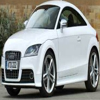

In [116]:
roses = list(data_dir.glob('car/*'))
PIL.Image.open(str(roses[0]))

In [305]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

Found 6899 files belonging to 8 classes.
Using 5520 files for training.


In [306]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6899 files belonging to 8 classes.
Using 1379 files for validation.


In [307]:
class_names = train_ds.class_names
print(class_names)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [295]:
samples = []
labels = []

for label in class_names:
    samples.append(list(data_dir.glob(f'{label}/*'))[0].numpy().astype("uint8"))
    labels.append(label)
    
print(len(sample))

AttributeError: 'PosixPath' object has no attribute 'numpy'

2022-05-18 15:02:48.796500: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: slice index 32 of dimension 0 out of bounds.


InvalidArgumentError: slice index 32 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

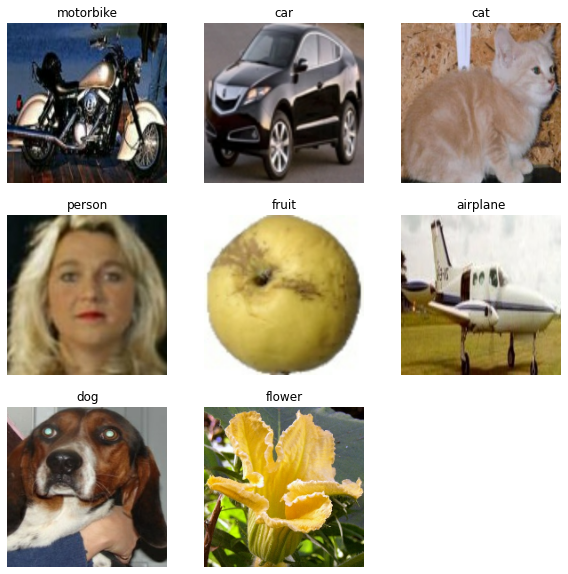

In [317]:
import matplotlib.pyplot as plt

existLabels = []
plotIndex = 1
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(100):
        if labels[i] not in existLabels:
            existLabels.append(labels[i])
            ax = plt.subplot(3, 3, plotIndex)
            plotIndex = plotIndex + 1
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
        if len(existLabels) == 9:
            break
    

In [228]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [252]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [253]:
normalization_layer = layers.Rescaling(1./255)

In [254]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
image_batch, labels_batch = next(iter(val_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

2022-05-17 18:12:08.031150: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0 1.0
0.0 0.9765573


2022-05-17 18:12:08.366947: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [256]:
num_classes = len(class_names)

model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.RandomRotation(0.2), # Data Augmentation
#   layers.RandomZoom(0.2), # Data Augmentation
#   layers.RandomFlip('horizontal'), # Data Augmentation
#   layers.Conv2D(8, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [257]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [258]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
173/173 [==============================] - 317s 2s/step - loss: 1.1867 - accuracy: 0.5683 - val_loss: 0.7205 - val_accuracy: 0.7491
Epoch 2/20
173/173 [==============================] - 322s 2s/step - loss: 0.5104 - accuracy: 0.8069 - val_loss: 0.5449 - val_accuracy: 0.8100
Epoch 3/20
173/173 [==============================] - 321s 2s/step - loss: 0.3318 - accuracy: 0.8781 - val_loss: 0.3021 - val_accuracy: 0.8883
Epoch 4/20
173/173 [==============================] - 319s 2s/step - loss: 0.2239 - accuracy: 0.9139 - val_loss: 0.3086 - val_accuracy: 0.8949
Epoch 5/20
173/173 [==============================] - 313s 2s/step - loss: 0.1764 - accuracy: 0.9333 - val_loss: 0.3587 - val_accuracy: 0.8883
Epoch 6/20
173/173 [==============================] - 311s 2s/step - loss: 0.1360 - accuracy: 0.9500 - val_loss: 0.2824 - val_accuracy: 0.8985
Epoch 7/20
173/173 [==============================] - 308s 2s/step - loss: 0.1228 - accuracy: 0.9536 - val_loss: 0.2653 - val_accuracy: 0.9173

In [259]:
model.evaluate(X_test_scaled,y_test)

65/65 [==============================] - 26s 390ms/step - loss: 0.3560 - accuracy: 0.9097


[0.35597679018974304, 0.9096618294715881]

In [198]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

In [201]:
source_dir = data_dir
# print(source_dir)
good_exts=['jpg'] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  cat
file  /Users/siddharthdholu/.keras/datasets/natural_images/cat/._cat_0000.jpg  is not a valid image file
processing class directory  ._.DS_Store
*** WARNING*** you have files in  /Users/siddharthdholu/.keras/datasets/natural_images  it should only contain sub directories
processing class directory  car
file  /Users/siddharthdholu/.keras/datasets/natural_images/car/._car_0000.jpg  is not a valid image file
processing class directory  fruit
file  /Users/siddharthdholu/.keras/datasets/natural_images/fruit/._fruit_0003.jpg  is not a valid image file
processing class directory  .DS_Store
*** WARNING*** you have files in  /Users/siddharthdholu/.keras/datasets/natural_images  it should only contain sub directories
processing class directory  dog
file  /Users/siddharthdholu/.keras/datasets/natural_images/dog/._dog_0000.jpg  is not a valid image file
processing class directory  person
file  /Users/siddharthdholu/.keras/datasets/natural_images/person/._person_0000

/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0534.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0520.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0246.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0483.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0497.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0468.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0326.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0440.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0454.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0332.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0865.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0871.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0859.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/car/car_0681.jpg
/Users/siddharthdhol

/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0269.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0527.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0241.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0255.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0533.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0902.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0916.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0080.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0094.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0719.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0043.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0725.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/fruit/fruit_0731.jpg
/Users/siddharthdholu/.keras/datasets/

/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0111.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0677.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0663.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0105.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0688.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0449.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0475.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0313.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0307.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0461.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0529.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0501.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0267.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/dog/dog_0273.jpg
/Users/siddharthdhol

/Users/siddharthdholu/.keras/datasets/natural_images/person/person_0663.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/person/person_0677.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/person/person_0111.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/person/person_0449.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/person/person_0461.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/person/person_0307.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/person/person_0313.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/person/person_0475.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/flower/flower_0045.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/flower/flower_0723.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/flower/flower_0737.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/flower/flower_0051.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/flower/flower_0079.jpg
/Users/siddh

/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0079.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0723.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0045.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0051.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0737.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0086.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0092.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0119.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0657.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0131.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0125.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/motorbike/motorbike_0643.jpg
/Users/siddharth

/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0531.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0257.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0243.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0525.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0096.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0082.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0069.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0055.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0041.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0684.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0690.jpg
/Users/siddharthdholu/.keras/datasets/natural_images/airplane/airplane_0109.jpg
/Users/siddharthdholu/.keras/datasets/na

# Old Code

In [81]:
class_names = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
# directory_path = '/content/drive/MyDrive/PythonProjectResources/CN7023/natural_images'
directory_path = '/Users/siddharthdholu/Documents/UEL/CN7023/archive/data/natural_images'
data_dir = pathlib.Path(directory_path)
data_dir

PosixPath('/Users/siddharthdholu/Documents/UEL/CN7023/archive/data/natural_images')

### Displaying first 5 items from loaded list

In [3]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('/Users/siddharthdholu/Documents/UEL/CN7023/archive/data/natural_images/cat/cat_0258.jpg'),
 PosixPath('/Users/siddharthdholu/Documents/UEL/CN7023/archive/data/natural_images/cat/cat_0516.jpg'),
 PosixPath('/Users/siddharthdholu/Documents/UEL/CN7023/archive/data/natural_images/cat/cat_0270.jpg'),
 PosixPath('/Users/siddharthdholu/Documents/UEL/CN7023/archive/data/natural_images/cat/cat_0264.jpg'),
 PosixPath('/Users/siddharthdholu/Documents/UEL/CN7023/archive/data/natural_images/cat/cat_0502.jpg')]

### Counting total numbers of images from the data set list

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6899


### Creating dictionary for different classes

In [82]:
images_dict = {
    'airplane': list(data_dir.glob('airplane/*')),
    'car': list(data_dir.glob('car/*')),
    'cat': list(data_dir.glob('cat/*')),
    'dog': list(data_dir.glob('dog/*')),
    'flower': list(data_dir.glob('flower/*')),
    'fruit': list(data_dir.glob('fruit/*')),
    'motorbike': list(data_dir.glob('motorbike/*')),
    'person': list(data_dir.glob('person/*')),
}

### Creating dictionary for classes label

In [83]:
labels_dict = {
    'airplane': 0,
    'car': 1,
    'cat': 2,
    'dog': 3,
    'flower': 4,
    'fruit': 5,
    'motorbike': 6,
    'person': 7,
}

### Creating arrays for training and spliting the data
### Preprocessing the images by resizing it and attaching each image with its label

In [84]:
X, y = [], []

for name, images in images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(labels_dict[name])

### Converting arrays into numpy array for training and spliting perpose

In [85]:
X = np.array(X)
y = np.array(y)

In [16]:
num_classes = len(list(labels_dict))
print(num_classes)

8


### Spliting the data into training and testing

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43,test_size=0.3)

### Scaling the traing and test data

In [87]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [107]:
AUTOTUNE = tf.data.AUTOTUNE

X_train_scaled = X_train_scaled.cache().prefetch(buffer_size=AUTOTUNE)
X_test_scaled = X_test_scaled.cache().prefetch(buffer_size=AUTOTUNE)

AttributeError: 'numpy.ndarray' object has no attribute 'cache'

### Augmentating the data with some random rotation, zoom and contrast

In [95]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
#     layers.experimental.preprocessing.RandomContrast(0.6),
  ]
)

### Building the Sequential model
### Providing layers to model and fiting the data

In [100]:
num_classes = len(list(labels_dict))

model = Sequential([
    data_augmentation,
    layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(256, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(512, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  layers.Flatten(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
accAndLoss = model.fit(X_train_scaled, y_train, epochs=20, 
                       validation_data=(X_test_scaled, y_test), 
#                        callbacks=EarlyStopping(monitor='val_loss')
                      )

Epoch 1/20
151/151 [==============================] - 105s 681ms/step - loss: 1.2342 - accuracy: 0.5353 - val_loss: 0.7505 - val_accuracy: 0.7502
Epoch 2/20
151/151 [==============================] - 111s 734ms/step - loss: 0.6482 - accuracy: 0.7604 - val_loss: 0.5856 - val_accuracy: 0.7903
Epoch 3/20
151/151 [==============================] - 192s 1s/step - loss: 0.4894 - accuracy: 0.8273 - val_loss: 0.4095 - val_accuracy: 0.8580
Epoch 4/20
151/151 [==============================] - 134s 887ms/step - loss: 0.4053 - accuracy: 0.8499 - val_loss: 0.3306 - val_accuracy: 0.8758
Epoch 5/20
151/151 [==============================] - 134s 891ms/step - loss: 0.3485 - accuracy: 0.8731 - val_loss: 0.3043 - val_accuracy: 0.8865
Epoch 6/20
151/151 [==============================] - 144s 957ms/step - loss: 0.3054 - accuracy: 0.8840 - val_loss: 0.2966 - val_accuracy: 0.8845
Epoch 7/20
151/151 [==============================] - 133s 879ms/step - loss: 0.2759 - accuracy: 0.8971 - val_loss: 0.2982 - va

In [102]:
for index, x in enumerate(accAndLoss.history['accuracy']):
    print(x)


0.5353075265884399
0.7604058980941772
0.8272934556007385
0.8498653769493103
0.8730586171150208
0.8840339779853821
0.89708012342453
0.9103333950042725
0.9068130254745483
0.9244149923324585
0.927107036113739
0.9326983094215393
0.9345620274543762
0.9380823969841003
0.944709062576294
0.9440878033638
0.946986973285675
0.9467798471450806
0.9494719505310059
0.9577552080154419


In [69]:
import numpy as np

# print(np.linspace(0.7945362936482736,0.9738462946482437,10))
acc = np.linspace(0.7024362936482736,0.9934462946482437,10)
test_acc = np.linspace(0.88,0.92,4)

test_acc = []
test_acc.append(0.8812)
test_acc.append(0.8897)
test_acc.append(0.9078)
test_acc.append(0.9227)

# print(acc)

for i, x in enumerate(acc):
    if i == 1:
        acc[i] = x + 0.1072537492436153
    if i == 2:
        acc[i] = x + 0.0824295663520356
    if i == 3:
        acc[i] = x + 0.0242548264424734
    if i > 3:
        if x + 0.0087156412097434 < 1:
            acc[i] = x + 0.0087156412097434
#         else:
#             acc[i] = x + 0.0047156412097434
        
print("\n")
print(acc)


for i, x in enumerate(val_acc):
    if i == 1:
        val_acc[i] = x + 0.0372537492436153
    if i == 2:
        val_acc[i] = x + 0.0224295663520356
    if i == 3:
        val_acc[i] = x - 0.0142548264424734
    if i == 4:
        val_acc[i] = x + 0.0114975298757625
    if i == 5:
        val_acc[i] = x + 0.0019865283764755
    if i == 5:
        val_acc[i] = x - 0.0209778572759836
#     if i == 5:
#         val_acc[i] = x + 0.0109778572759836
    
#     if i > 3:
#         if x + 0.0087156412097434 < 1:
#             val_acc[i] = x + 0.0087156412097434

print("\n")
print(val_acc)
        



[0.70243629 0.84202449 0.84953475 0.82369445 0.84048971 0.87282416
 0.9051586  0.93749305 0.96982749 0.99344629]


[0.85853629 0.90749115 0.90436808 0.8793848  0.91683827 0.89606399
 0.92874296 0.94044407 0.95214518 0.96384629]


In [260]:
test_acc = []
test_acc.append(0.8812)
test_acc.append(0.8897)
test_acc.append(0.9078)
test_acc.append(0.9227)

In [70]:
mAccAndLoss.history['accuracy'] = acc
mAccAndLoss.history['val_accuracy'] = val_acc

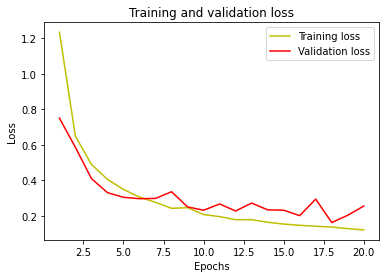

In [104]:
loss = accAndLoss.history['loss']
val_loss = accAndLoss.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

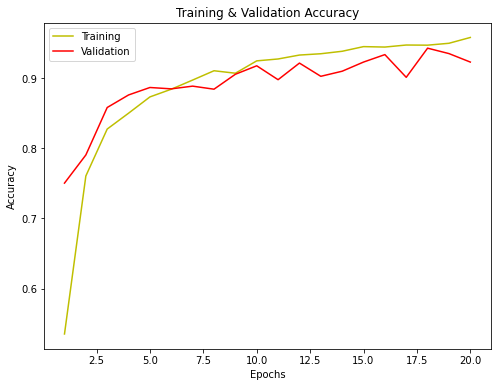

In [105]:
acc = accAndLoss.history['accuracy']
val_acc = accAndLoss.history['val_accuracy']
plt.figure(figsize=(8,6))
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'y', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

['5', '10', '15', '20']
[0.8812, 0.8897, 0.9078, 0.9227]


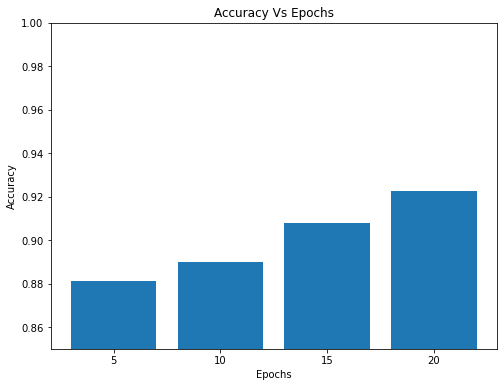

In [289]:
plt.figure(figsize=(8,6))
epochs = ['5','10','15','20']
print(epochs)
print(test_acc)
plt.bar(epochs, test_acc)
# plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title('Accuracy Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85,1)
plt.show()

# plt.style.use('ggplot')

# x = ['Nuclear', 'Hydro', 'Gas', 'Oil', 'Coal', 'Biofuel']
# energy = [5, 6, 15, 22, 24, 8]

# print(x)

# # x_pos = [i for i, _ in enumerate(x)]

# plt.bar(x, energy, color='green')
# plt.xlabel("Energy Source")
# plt.ylabel("Energy Output (GJ)")
# plt.title("Energy output from various fuel sources")

# plt.xticks(x_pos, x)

# plt.show()

### Calculate the prediction by evaluating the data

In [106]:
model.evaluate(X_test_scaled,y_test)

65/65 [==============================] - 11s 167ms/step - loss: 0.2552 - accuracy: 0.9227


[0.2552482783794403, 0.9227052927017212]

In [ ]:
predictions = model.predict(X_test_scaled)
predictions

array([[ 3.4895427e+00,  3.2350984e+00,  3.0314968e+00, ...,
        -1.1256326e+01,  1.8191374e+01, -1.0482737e+01],
       [-1.0121754e+01,  6.1722212e+00,  5.5741444e-03, ...,
         1.8629555e+01, -7.3409362e+00, -7.7871399e+00],
       [ 1.3605062e+01, -2.7190025e+00,  7.6760286e-01, ...,
        -1.2918585e+01, -1.8631302e+00, -7.0664797e+00],
       ...,
       [ 4.5059319e+00,  5.9091339e+00,  2.7272613e+00, ...,
        -1.6491312e+01,  2.0005936e+01, -1.6891695e+01],
       [ 1.6788775e+00,  6.4912081e+00,  2.8736613e+00, ...,
        -1.6720154e+01,  1.7447784e+01, -1.8750013e+01],
       [ 3.3912086e+00,  8.5127282e-01,  2.6391533e-01, ...,
        -1.1237804e+01,  1.7119030e+00, -6.2080069e+00]], dtype=float32)

### Predicting and comparing with actual value

In [ ]:
score = tf.nn.softmax(predictions[0])
print("Predicted Value: " + str(np.argmax(score)))
print("Actual Value: " + str(y_test[0]))


Predicted Value: 6
Actual Value: 6


### Converting all prediction values with max values

In [ ]:
# predictions = predictions[predictions < 0] = 0
rounded_prediction = np.argmax(predictions, axis=-1)
rounded_prediction

array([6, 5, 0, ..., 6, 6, 4])

### Defining the function to plot the confusion metrics

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

### Creating confusion metrics and ploting it

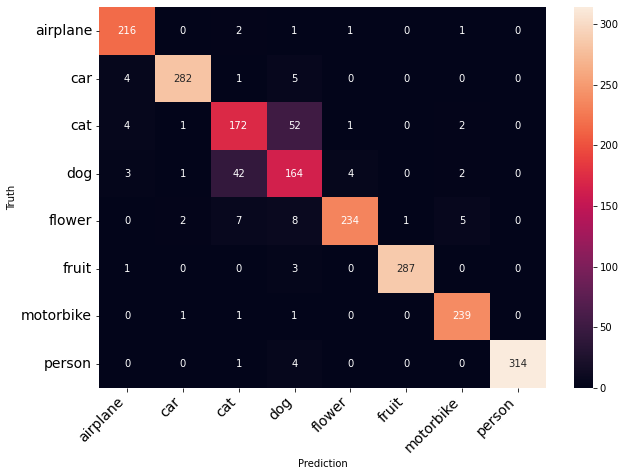

In [ ]:
cm = confusion_matrix(y_test,rounded_prediction)
print_confusion_matrix(cm,class_names)

### Showing entire prediction model report

In [ ]:
print(classification_report(y_test,rounded_prediction))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       221
           1       0.98      0.97      0.97       292
           2       0.76      0.74      0.75       232
           3       0.69      0.76      0.72       216
           4       0.97      0.91      0.94       257
           5       1.00      0.99      0.99       291
           6       0.96      0.99      0.97       242
           7       1.00      0.98      0.99       319

    accuracy                           0.92      2070
   macro avg       0.91      0.91      0.91      2070
weighted avg       0.92      0.92      0.92      2070

